### NYC Arrests - Crime

<hr>

This notebook extracts NYC arrest data from NYC OpenData. Data is then processed and exported to a CSV file which is then imported into Tableau for data visualization.

Before running this notebook, ensure you have the following shape files:
<ul>
   <li>Neighborhood Tabluation Areas (NTA)</li>
   <li>Police Precincts</li> 
<ul>

<hr>

### Imports

In [1]:
#!/usr/bin/env python

# make sure to install necessary packages before running
# GeoPandas might be a bit difficult to install

import os
import datetime
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sodapy import Socrata

import geopandas
from shapely.geometry import Point

C:\Users\alexc\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Get data from NYC OpenData

In [2]:
socrata_domain = 'data.cityofnewyork.us'

# NYPD Arrest Data (Year to Date)
socrata_dataset_identifier_ny_data_ytd = 'uip8-fykc'

# NYPD Arrest Data (Historic)
socrata_dataset_identifier_ny_data_his = '8h9b-rp9u'

# read application token
with open('app-token.txt', 'r') as fp:
    contents = fp.read()
socrata_token = contents

# connect to data
client = Socrata(socrata_domain, socrata_token)

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata('data.cityofnewyork.us',
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# results = client.get(socrata_dataset_identifier, limit=1000)

# Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

#### Metadata associated with the data pull

In [3]:
# Metadata
# metadata = client.get_metadata(socrata_dataset_identifier_ny_data_ytd)
# metadata_columns = [x['name'] for x in metadata['columns']]
# metadata_columns

In [4]:
# Metadata for a particular column
# meta_arrest_col_date = [x for x in metadata['columns'] if x['name'] == 'ARREST_DATE'][0]
# meta_arrest_col

#### Get date range of the data and size of data

In [5]:
# get date range of data
# note: string is returned
# most_recent_date = meta_arrest_col_date['cachedContents']['largest']
# oldest_date = meta_arrest_col_date['cachedContents']['smallest']
# num_of_results = int(meta_arrest_col_date['cachedContents']['not_null'])

# print("Most recent date: " + most_recent_date)
# print("Oldest date: " + oldest_date)
# print("Total number of not null results: "+ str(num_of_results))

### Get the data using the API

In [6]:
# Get data from start_date to end of previous calendar year
start_date = '2017-01-01'

# loop through the results (to prevent data from crashing)
loop_size = 10000

data = []
results = True
i = 0
while(results):
    results = client.get(socrata_dataset_identifier_ny_data_his, 
#                          where="ARREST_DATE >= '2019-01-01T00:00:00.000'",
                         where = f"ARREST_DATE >= '{start_date}T00:00:00.000'",
                         # select="column1,column2,etc",
                         # order="column1 ASC",
                         # can also do other operations 
                         limit=loop_size,
                         offset=loop_size * i)
    i += 1
    data.extend(results)

In [7]:
# Get data from year to date

now = datetime.datetime.now()
current_year =  now.year

results = True
i = 0
while(results):
    results = client.get(socrata_dataset_identifier_ny_data_ytd, 
                         where= f"ARREST_DATE >= '{current_year}-01-01T00:00:00.000'",
                         limit=loop_size,
                         offset=loop_size * i)
    i += 1
    data.extend(results)

In [8]:
# put the data in a pandas dataframe
results_df = pd.DataFrame(data)

### Quick exploration of data

In [9]:
# What is law_cat_cd with value 'I'? Likely Traffic Infraction
results_df.loc[results_df['law_cat_cd'] == 'I'].head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
21,159824794,2017-01-01T00:00:00.000,961.0,"SIGNAL,FAIL TO",881.0,OTHER TRAFFIC INFRACTION,VTL116300D,I,S,122,0.0,45-64,M,WHITE,954840.0,152574.0,40.58541590000005,-74.10588525399999
88,159827162,2017-01-01T00:00:00.000,969.0,"TRAFFIC,UNCLASSIFIED INFRACTIO",881.0,OTHER TRAFFIC INFRACTION,VTL1192AI1,I,M,26,0.0,25-44,M,WHITE HISPANIC,995462.0,236938.0,40.817016896000034,-73.95949480499998
150,159840207,2017-01-01T00:00:00.000,969.0,"TRAFFIC,UNCLASSIFIED INFRACTION",881.0,OTHER TRAFFIC INFRACTION,VTL038301C,I,K,73,0.0,25-44,M,WHITE HISPANIC,1009011.0,183273.0,40.669692375000075,-73.91074262999997
384,159831271,2017-01-01T00:00:00.000,969.0,"TRAFFIC,UNCLASSIFIED INFRACTIO",881.0,OTHER TRAFFIC INFRACTION,VTL1192AI1,I,M,25,0.0,25-44,F,WHITE,1003297.0,231385.0,40.80176203400004,-73.931204327
433,159829757,2017-01-01T00:00:00.000,940.0,LEAVING SCENE-ACCIDENT-PROP. DAMAGE,881.0,OTHER TRAFFIC INFRACTION,VTL060001A,I,B,47,0.0,25-44,M,BLACK,1025087.0,267578.0,40.90102711600008,-73.85227923599997


In [10]:
# quick summary of data
results_df.describe()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
count,792439,792439,792327,790514,790514,790514,792394,787413,792439,792439,792439,792439,792439,792439,792439,792439,792439,792439
unique,791512,1186,581,393,142,82,1607,4,5,77,51,5,2,7,75250,80107,65941,65942
top,182334670,2017-02-08T00:00:00.000,101,ASSAULT 3,344,ASSAULT 3 & RELATED OFFENSES,PL 1552500,M,K,14,0,25-44,M,BLACK,1046315,187088,40.67998073800004,-73.77623390699993
freq,2,1245,56389,82670,66323,107085,72221,495077,218834,24943,442411,411224,650821,377825,3532,3535,4771,4771


### Clean data to make analysis easier

In [11]:
# change arrest_boro abbreviation to long form
boro_dict = {
    'B': 'Bronx',
    'S': 'Staten Island',
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens',
}
results_df['arrest_boro'] = results_df.arrest_boro.replace(boro_dict)

# change perp_sex abbreviation to long form
perp_sex_dict = {
    'F': 'Female',
    'M': 'Male',
}
results_df['perp_sex'] = results_df.perp_sex.replace(perp_sex_dict)

# change law_cat_cd abbreviation to long form
law_cat_cd_dict = {
    'F': 'Felony',
    'M': 'Misdemeanor',
    'V': 'Violation',
    'I': 'Traffic Infraction',
}
results_df['law_cat_cd'] = results_df['law_cat_cd'].replace(law_cat_cd_dict)

In [12]:
# change perp_race from all caps to title case
results_df['perp_race'] = results_df['perp_race'].apply(lambda x: x.title())

# change perp_race from all caps to title case
results_df['ofns_desc'] = results_df['ofns_desc'].astype(str)
results_df['ofns_desc'] = results_df['ofns_desc'].apply(lambda x: x.title())

In [13]:
# change latitude and longitude from string to numeric
results_df['latitude'] = pd.to_numeric(results_df['latitude'])
results_df['longitude'] = pd.to_numeric(results_df['longitude'])
# print(results_df.dtypes)

### Prepare data for spatial analysis
##### Note: this step may take a long time

In [14]:
# add a column of the neighborhood name within NYC (for Tableau)

url = r"Data\Spatial Files\Neighborhood Tabulation Areas (NTA)\geo_export_0c82a76e-3045-414c-9b45-6c529ffc990f.shp"
gdf_locations = geopandas.read_file(url)

# convert to GeoDataFrame and create a column of shapely points
gdf = geopandas.GeoDataFrame(
    results_df, geometry=geopandas.points_from_xy(x=results_df.longitude, y=results_df.latitude)
)

def get_ntaname(shapely_point):
    """Returns the neighborhood name in NYC given a Shapely Point"""
    filter_ = gdf_locations['geometry'].contains(shapely_point)
    ntaname_pd_series = gdf_locations.loc[filter_, 'ntaname']
    if(len(ntaname_pd_series)==0):
        return "Unknown"
    else:
        ntaname = ntaname_pd_series.to_string(index=False).strip()
        return ntaname

# create a new column with the nyc neighborhood
# is there a faster way to do this? vectorize?
gdf['neighborhood'] = gdf['geometry'].map(get_ntaname)

In [15]:
# unknown neighborhoods (remove in Tableau)
unknown_neighborhoods_df = gdf[gdf['neighborhood'] == "Unknown"]

print(unknown_neighborhoods_df.shape)
# print(unknown_neighborhoods_df)

(137, 20)


In [16]:
results_df.head()

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude,geometry,neighborhood
0,159828204,2017-01-01T00:00:00.000,106.0,"ASSAULT 2,1,PEACE OFFICER",106.0,Felony Assault,PL 12005A3,Felony,Manhattan,19,0.0,18-24,Male,Black,994948.0,221998.0,40.776011,-73.961376,POINT (-73.96138 40.77601),Upper East Side-Carnegie Hill
1,159839410,2017-01-01T00:00:00.000,969.0,"TRAFFIC,UNCLASSIFIED INFRACTION",881.0,Other Traffic Infraction,VTL051101A,Misdemeanor,Staten Island,122,0.0,18-24,Male,White,956906.0,151054.0,40.581250,-74.098441,POINT (-74.09844 40.58125),Old Town-Dongan Hills-South Beach
2,159834534,2017-01-01T00:00:00.000,203.0,"TRESPASS 3, CRIMINAL",352.0,Criminal Trespass,PL 1401000,Misdemeanor,Brooklyn,60,2.0,<18,Male,Black,986229.0,148311.0,40.573763,-73.992878,POINT (-73.99288 40.57376),Seagate-Coney Island
3,159835574,2017-01-01T00:00:00.000,879.0,"ADM.CODE,UNCLASSIFIED VIOLATION",675.0,Administrative Code,AC 010125B,Violation,Brooklyn,79,0.0,25-44,Male,Asian / Pacific Islander,996546.0,187436.0,40.681145,-73.955669,POINT (-73.95567 40.68114),Clinton Hill
4,159835585,2017-01-01T00:00:00.000,905.0,"INTOXICATED DRIVING,ALCOHOL",347.0,Intoxicated & Impaired Driving,VTL11920U2,Misdemeanor,Manhattan,26,0.0,25-44,Male,White Hispanic,995131.0,237121.0,40.817520,-73.960690,POINT (-73.96069 40.81752),Manhattanville


In [24]:
### Drop unnecessary columns
results_df.drop(columns=['arrest_key', 'x_coord_cd', 'y_coord_cd', 'geometry'], inplace=True)

### Summary of data and some data visualization

In [17]:
# unique arrest_boro
print(results_df.arrest_boro.unique())

# unique perp_sex
print()
print(results_df.perp_sex.unique())

# unique perp_race
print()
print(results_df.perp_race.unique())

# unique perp_race
print()
print(results_df['law_cat_cd'].value_counts(dropna=False))

# unique pd_desc
print()
unique_pd_desc = results_df.pd_desc.unique()
print(len(unique_pd_desc))

print()
print(results_df['arrest_boro'].value_counts(dropna=False))

print()
print(results_df['jurisdiction_code'].value_counts(dropna=False))


print()
print(results_df['neighborhood'].value_counts(dropna=False))

print()
print(results_df.shape)

print()
print(results_df.dtypes)

['Manhattan' 'Staten Island' 'Brooklyn' 'Queens' 'Bronx']

['Male' 'Female']

['Black' 'White' 'Asian / Pacific Islander' 'White Hispanic'
 'Black Hispanic' 'Unknown' 'American Indian/Alaskan Native']

Misdemeanor           495077
Felony                278085
Violation              11912
NaN                     5026
Traffic Infraction      2339
Name: law_cat_cd, dtype: int64

394

Brooklyn         218834
Manhattan        204133
Bronx            177141
Queens           159544
Staten Island     32787
Name: arrest_boro, dtype: int64

0       442411
0.0     237974
1.0      22679
1        21721
2        19496
2.0      16109
97        7425
3         6639
3.0       2890
97.0      2456
72        1812
4         1338
6         1312
72.0      1210
11         951
73         746
4.0        534
15         516
7          470
6.0        431
73.0       356
11.0       355
14         353
71         337
15.0       266
7.0        171
14.0       164
69.0       157
87         118
9          102
85          9

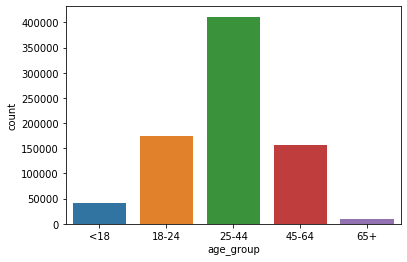

In [18]:
def order_labels(age_group_labels):
    """Returns age_group label sorted in ascending order"""
    ordered_labels = sorted(list(age_group_labels))
    last_item = ordered_labels.pop()
    ordered_labels.insert(0, last_item)
    return ordered_labels
    
age_group_labels = order_labels(results_df.age_group.unique())

sns.countplot(results_df['age_group'], order=age_group_labels)

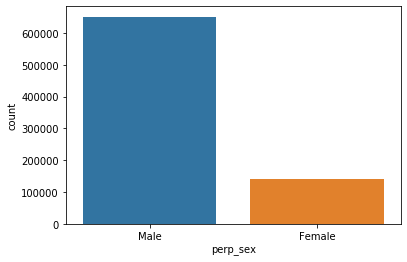

In [19]:
sns.countplot(results_df['perp_sex'], )

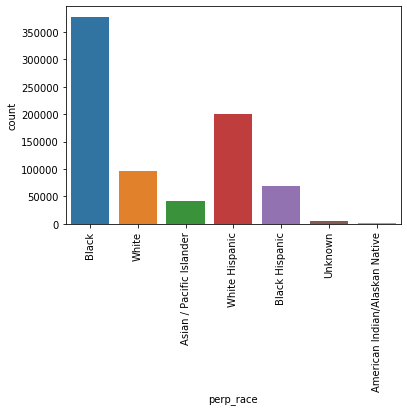

In [20]:
plot_race = sns.countplot(results_df['perp_race'], )
tick_labels = plot_race.get_xticklabels()
plot_race = plot_race.set_xticklabels(tick_labels, rotation=90)

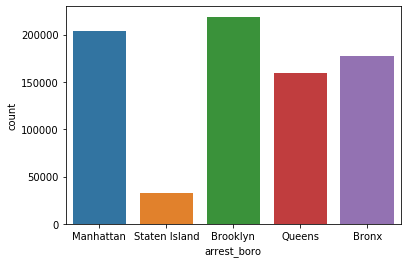

In [21]:
sns.countplot(results_df['arrest_boro'], )

In [27]:
# export Pandas DataFrame to csv
today = datetime.date.today()
results_df.to_csv(f"Archived Files/{today}_nypd-arrests.csv", index_label="unique_id")